In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import IterableDataset, DataLoader, Dataset

from torch.utils.tensorboard import SummaryWriter
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
positive_file = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/positive_new.txt'
negative_file = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/negative_new.txt'

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout=0.0):
        super(TransformerEncoderBlock, self).__init__()
        self.layernorm1 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        self.layernorm2 = nn.LayerNorm(embedding_dim, eps=1e-6)
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        x1 = self.layernorm1(x)
        attn_output, _ = self.mha(x1, x1, x1)
        out1 = self.dropout1(attn_output) + x  
        x2 = self.layernorm2(out1)
        ffn_output = self.ffn(x2)
        out2 = ffn_output + out1  
        return out2
   

class AbsDiffLayer(nn.Module):
    def __init__(self):
        super(AbsDiffLayer, self).__init__()

    def forward(self, x1, x2):
        return torch.abs(x1 - x2)

class SpatialDropout1D(nn.Module):
    def __init__(self, p):
        super(SpatialDropout1D, self).__init__()
        self.dropout = nn.Dropout2d(p)

    def forward(self, x):
        x = x.permute(0, 2, 1).unsqueeze(-1)  
        x = self.dropout(x)
        x = x.squeeze(-1).permute(0, 2, 1)    
        return x

class SiameseModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(SiameseModel, self).__init__()
        self.max_len = max_len
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.position_embedding = nn.Embedding(num_embeddings=max_len, embedding_dim=embedding_dim)
        self.spatial_dropout = SpatialDropout1D(p=0.2)
        self.bilstm = nn.LSTM(input_size=embedding_dim, hidden_size=64, num_layers=1,
                                bidirectional=True, batch_first=True)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embedding_dim=128, num_heads=4, ff_dim=128, dropout=0.2)
            for _ in range(4)
        ])
        self.abs_diff = AbsDiffLayer()
        self.fc = nn.Sequential(
            nn.Linear(384, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_a, input_b):
        batch_size = input_a.size(0)
        device = input_a.device
        embedded_a = self.embedding(input_a)
        embedded_b = self.embedding(input_b)
        positions = torch.arange(0, self.max_len, device=device).unsqueeze(0).expand(batch_size, self.max_len)
        position_embeddings = self.position_embedding(positions)
        embedded_a = embedded_a + position_embeddings
        embedded_b = embedded_b + position_embeddings
        embedded_a = self.spatial_dropout(embedded_a)
        embedded_b = self.spatial_dropout(embedded_b)
        output_a, _ = self.bilstm(embedded_a)
        output_b, _ = self.bilstm(embedded_b)
        for transformer_block in self.transformer_blocks:
            output_a = transformer_block(output_a)
            output_b = transformer_block(output_b)
        hidden_a = torch.mean(output_a, dim=1)  
        hidden_b = torch.mean(output_b, dim=1)
        diff = self.abs_diff(hidden_a, hidden_b)
        combined_features = torch.cat((hidden_a, hidden_b, diff), dim=1)
        output = self.fc(combined_features)
        # output = self.sigmoid(output)
        return output

In [4]:
def load_characters_from_file(file_path):
    chars = set()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split()
            if len(parts) >= 3:
                word1, word2, _ = parts[:3]
                chars.update(word1)
                chars.update(word2)
            else:
                print(f"Warning: Line {line_number} in {file_path} does not contain enough data and will be skipped.")
    return chars

positive_chars = load_characters_from_file(positive_file)
negative_chars = load_characters_from_file(negative_file)
all_chars = positive_chars.union(negative_chars)

In [5]:
char_list = sorted(all_chars)
char_to_index = {char: idx + 2 for idx, char in enumerate(char_list)}  # Смещение на 2 для специальных токенов
char_to_index['<PAD>'] = 0
char_to_index['<UNK>'] = 1
index_to_char = {idx: char for char, idx in char_to_index.items()}

vocab_size = len(char_to_index)
print(f"Размер словаря: {vocab_size}")

Размер словаря: 2930


In [6]:
def char_tokenizer(text):
    return [char_to_index.get(char, char_to_index['<UNK>']) for char in text]

In [7]:
def load_sequences_from_file(file_path, tokenizer):
    sequences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split()
            if len(parts) >= 3:
                word1, word2, _ = parts[:3]
                seq1 = tokenizer(word1)
                seq2 = tokenizer(word2)
                sequences.extend([seq1, seq2])
            else:
                print(f"Warning: Line {line_number} in {file_path} does not contain enough data and will be skipped.")
    return sequences

positive_sequences = load_sequences_from_file(positive_file, char_tokenizer)
negative_sequences = load_sequences_from_file(negative_file, char_tokenizer)
all_sequences = positive_sequences + negative_sequences

sequence_lengths = [len(seq) for seq in all_sequences]
sequence_length = max(sequence_lengths)
print(f"Максимальная длина последовательности: {sequence_length}")

Максимальная длина последовательности: 43


In [8]:
def pad_or_truncate(tokens, max_len, pad_index):
    if len(tokens) > max_len:
        return tokens[:max_len]
    else:
        return tokens + [pad_index] * (max_len - len(tokens))

In [9]:
def load_dataset(positive_file, negative_file, tokenizer, max_seq_length, pad_index):
    dataset = []
    # Загрузка положительных примеров
    with open(positive_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split('\t')
            if len(parts) >= 2:
                seq1, seq2 = parts[:2]
                tokens1 = tokenizer(seq1)
                tokens2 = tokenizer(seq2)
                tokens1 = pad_or_truncate(tokens1, max_seq_length, pad_index)
                tokens2 = pad_or_truncate(tokens2, max_seq_length, pad_index)
                dataset.append({
                    'sequence1': torch.tensor(tokens1, dtype=torch.long),
                    'sequence2': torch.tensor(tokens2, dtype=torch.long),
                    'label': torch.tensor(1, dtype=torch.float)
                })
            else:
                print(f"Warning: Line {line_number} in {positive_file} does not contain enough data and will be skipped.")
    # Загрузка отрицательных примеров
    with open(negative_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split()
            if len(parts) >= 2:
                seq1, seq2 = parts[:2]
                tokens1 = tokenizer(seq1)
                tokens2 = tokenizer(seq2)
                tokens1 = pad_or_truncate(tokens1, max_seq_length, pad_index)
                tokens2 = pad_or_truncate(tokens2, max_seq_length, pad_index)
                dataset.append({
                    'sequence1': torch.tensor(tokens1, dtype=torch.long),
                    'sequence2': torch.tensor(tokens2, dtype=torch.long),
                    'label': torch.tensor(0, dtype=torch.float)
                })
            else:
                print(f"Warning: Line {line_number} in {negative_file} does not contain enough data and will be skipped.")
    return dataset

def pad_or_truncate(tokens, max_len, pad_index):
    if len(tokens) > max_len:
        return tokens[:max_len]
    else:
        return tokens + [pad_index] * (max_len - len(tokens))
    

In [10]:
train_data = load_dataset(positive_file, negative_file, char_tokenizer, sequence_length, char_to_index['<PAD>'])
random.shuffle(train_data)

In [24]:
test_positive = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/positive_test.txt'
test_negative = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/negative_test.txt'

In [32]:
test_data = load_dataset(test_positive, test_negative, char_tokenizer, sequence_length, char_to_index['<PAD>'])
random.shuffle(test_data)

In [16]:
writer = SummaryWriter(log_dir='logs/siamese_model')

In [17]:
embedding_dim = 128
max_len = sequence_length
batch_size = 32
num_epochs = 10
learning_rate = 1e-3

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = SiameseModel(vocab_size=vocab_size, embedding_dim=embedding_dim, max_len=max_len).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Эпоха [1/10], Функция потерь: 0.0796
Эпоха [2/10], Функция потерь: 0.0554
Эпоха [3/10], Функция потерь: 0.0487
Эпоха [4/10], Функция потерь: 0.0452
Эпоха [5/10], Функция потерь: 0.0443
Эпоха [6/10], Функция потерь: 0.0425
Эпоха [7/10], Функция потерь: 0.0421
Эпоха [8/10], Функция потерь: 0.0414
Эпоха [9/10], Функция потерь: 0.0410
Эпоха [10/10], Функция потерь: 0.0406


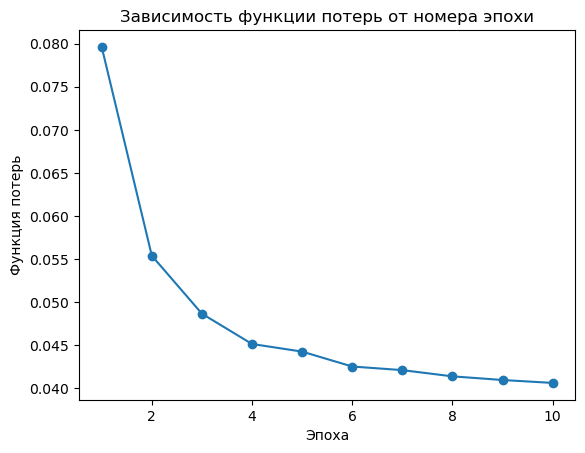

In [18]:
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        input_a = batch['sequence1'].to(device)
        input_b = batch['sequence2'].to(device)
        labels = batch['label'].unsqueeze(1).float().to(device)

        optimizer.zero_grad()
        outputs = model(input_a, input_b)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

    epoch_loss = running_loss / len(train_data)
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    train_losses.append(epoch_loss)
    print(f'Эпоха [{epoch+1}/{num_epochs}], Функция потерь: {epoch_loss:.4f}')
writer.close()

# Визуализация функции потерь по эпохам
plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.xlabel('Эпоха')
plt.ylabel('Функция потерь')
plt.title('Зависимость функции потерь от номера эпохи')
plt.show()

In [33]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [35]:
model.eval()
test_losses = []
with torch.no_grad():
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    for batch in test_loader:
        input_a = batch['sequence1'].to(device)
        input_b = batch['sequence2'].to(device)
        labels = batch['label'].unsqueeze(1).float().to(device)

        outputs = model(input_a, input_b)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * labels.size(0)

        # Вычисление точности
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities >= 0.5).float()
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    test_loss = running_loss / len(test_data)
    accuracy = total_correct / total_samples
    test_losses.append(test_loss)
    print(f'Валидационная функция потерь: {test_loss:.4f}, Точность: {accuracy:.4f}')

Валидационная функция потерь: 5.3893, Точность: 0.6230


In [22]:
torch.save(model.state_dict(), 'model.pth')

### Дообучение

In [11]:
def load_characters_from_file(file_path):
    chars = set()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split()
            if len(parts) >= 5:  # Проверяем, что строка содержит достаточно данных
                word1, translation1, word2, translation2, _ = parts[:5]
                chars.update(word1)
                chars.update(translation1)
                chars.update(word2)
                chars.update(translation2)
            else:
                print(f"Warning: Line {line_number} in {file_path} does not contain enough data and will be skipped.")
    return chars

In [12]:
def load_sequences_from_file(file_path, tokenizer):
    sequences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split()
            if len(parts) >= 5:  # Проверяем, что строка содержит достаточно данных
                word1, translation1, word2, translation2, _ = parts[:5]
                seq1 = tokenizer(word1)
                seq2 = tokenizer(translation1)
                seq3 = tokenizer(word2)
                seq4 = tokenizer(translation2)
                sequences.extend([seq1, seq2, seq3, seq4])
            else:
                print(f"Warning: Line {line_number} in {file_path} does not contain enough data and will be skipped.")
    return sequences

In [13]:
def load_dataset(positive_file, negative_file, tokenizer, max_seq_length, pad_index):
    dataset = []
    # Загрузка положительных примеров
    with open(positive_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split('\t')  # Разделяем строку по табуляции
            if len(parts) >= 5:  # Проверяем, что строка содержит достаточно данных
                word1, translation1, word2, translation2, label = parts[:5]
                tokens1 = tokenizer(word1)
                tokens2 = tokenizer(translation1)
                tokens3 = tokenizer(word2)
                tokens4 = tokenizer(translation2)
                tokens1 = pad_or_truncate(tokens1, max_seq_length, pad_index)
                tokens2 = pad_or_truncate(tokens2, max_seq_length, pad_index)
                tokens3 = pad_or_truncate(tokens3, max_seq_length, pad_index)
                tokens4 = pad_or_truncate(tokens4, max_seq_length, pad_index)
                dataset.append({
                    'word1': torch.tensor(tokens1, dtype=torch.long),
                    'translation1': torch.tensor(tokens2, dtype=torch.long),
                    'word2': torch.tensor(tokens3, dtype=torch.long),
                    'translation2': torch.tensor(tokens4, dtype=torch.long),
                    'label': torch.tensor(int(label), dtype=torch.float)  # Преобразуем метку в число
                })
            else:
                print(f"Warning: Line {line_number} in {positive_file} does not contain enough data and will be skipped.")
    # Загрузка отрицательных примеров
    with open(negative_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            parts = line.strip().split('\t')  
            if len(parts) >= 5:  
                word1, translation1, word2, translation2, label = parts[:5]
                tokens1 = tokenizer(word1)
                tokens2 = tokenizer(translation1)
                tokens3 = tokenizer(word2)
                tokens4 = tokenizer(translation2)
                tokens1 = pad_or_truncate(tokens1, max_seq_length, pad_index)
                tokens2 = pad_or_truncate(tokens2, max_seq_length, pad_index)
                tokens3 = pad_or_truncate(tokens3, max_seq_length, pad_index)
                tokens4 = pad_or_truncate(tokens4, max_seq_length, pad_index)
                dataset.append({
                    'word1': torch.tensor(tokens1, dtype=torch.long),
                    'translation1': torch.tensor(tokens2, dtype=torch.long),
                    'word2': torch.tensor(tokens3, dtype=torch.long),
                    'translation2': torch.tensor(tokens4, dtype=torch.long),
                    'label': torch.tensor(int(label), dtype=torch.float)  # Преобразуем метку в число
                })
            else:
                print(f"Warning: Line {line_number} in {negative_file} does not contain enough data and will be skipped.")
    return dataset

In [14]:
positive_file = '/Users/oksanagoncarova/Desktop/ipynb/1/all_pairs.txt'
negative_file = '/Users/oksanagoncarova/Desktop/ipynb/1/negative1.txt'
test_positive = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/positive_test7.txt'
test_negative = '/Users/oksanagoncarova/Desktop/ipynb/Новая папка 3/negative_test7.txt'

In [15]:
# Загрузка символов
positive_chars = load_characters_from_file(positive_file)
negative_chars = load_characters_from_file(negative_file)
all_chars = positive_chars.union(negative_chars)
char_list = sorted(all_chars)
char_to_index = {char: idx + 2 for idx, char in enumerate(char_list)}  # Смещение на 2 для специальных токенов
char_to_index['<PAD>'] = 0
char_to_index['<UNK>'] = 1
index_to_char = {idx: char for char, idx in char_to_index.items()}

# vocab_size = len(char_to_index)
# print(f"Размер словаря: {vocab_size}")

# Токенизатор
def char_tokenizer(text):
    tokens = [char_to_index.get(char, char_to_index['<UNK>']) for char in text]
    # print(f"Tokenized '{text}' to {tokens}")
    return tokens

# Загрузка последовательностей
positive_sequences = load_sequences_from_file(positive_file, char_tokenizer)
negative_sequences = load_sequences_from_file(negative_file, char_tokenizer)
all_sequences = positive_sequences + negative_sequences

# # Определение максимальной длины последовательности
# sequence_lengths = [len(seq) for seq in all_sequences]
# sequence_length = max(sequence_lengths)
# print(f"Максимальная длина последовательности: {sequence_length}")

# Загрузка датасета
train_data = load_dataset(positive_file, negative_file, char_tokenizer, sequence_length, char_to_index['<PAD>'])
random.shuffle(train_data)

test_data = load_dataset(test_positive, test_negative, char_tokenizer, sequence_length, char_to_index['<PAD>'])
random.shuffle(test_data)

In [16]:
class SiameseModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_len):
        super(SiameseModel, self).__init__()
        self.max_len = max_len
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.position_embedding = nn.Embedding(num_embeddings=max_len, embedding_dim=embedding_dim)
        self.spatial_dropout = SpatialDropout1D(p=0.2)
        self.bilstm = nn.LSTM(input_size=embedding_dim, hidden_size=64, num_layers=1,
                              bidirectional=True, batch_first=True)
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embedding_dim=128, num_heads=4, ff_dim=128, dropout=0.2)
            for _ in range(4)
        ])
        self.abs_diff = AbsDiffLayer()
        self.fc_old = nn.Sequential(
            nn.Linear(384, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc_new = nn.Sequential(
            nn.Linear(768, 384),  
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc_final = nn.Sequential(
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

        self.sigmoid = nn.Sigmoid()
    
    def forward(self, word1, translation1, word2, translation2):
        batch_size = word1.size(0)
        device = word1.device
        embedded_word1 = self.embedding(word1)
        embedded_translation1 = self.embedding(translation1)
        positions = torch.arange(0, self.max_len, device=device).unsqueeze(0).expand(batch_size, self.max_len)
        position_embeddings = self.position_embedding(positions)
        embedded_word1 = embedded_word1 + position_embeddings
        embedded_translation1 = embedded_translation1 + position_embeddings
        embedded_word1 = self.spatial_dropout(embedded_word1)
        embedded_translation1 = self.spatial_dropout(embedded_translation1)
        output_word1, _ = self.bilstm(embedded_word1)
        output_translation1, _ = self.bilstm(embedded_translation1)
        for transformer_block in self.transformer_blocks:
            output_word1 = transformer_block(output_word1)
            output_translation1 = transformer_block(output_translation1)
        hidden_word1 = torch.mean(output_word1, dim=1)
        hidden_translation1 = torch.mean(output_translation1, dim=1)
        embedded_word2 = self.embedding(word2)
        embedded_translation2 = self.embedding(translation2)
        embedded_word2 = embedded_word2 + position_embeddings
        embedded_translation2 = embedded_translation2 + position_embeddings
        embedded_word2 = self.spatial_dropout(embedded_word2)
        embedded_translation2 = self.spatial_dropout(embedded_translation2)
        output_word2, _ = self.bilstm(embedded_word2)
        output_translation2, _ = self.bilstm(embedded_translation2)
        for transformer_block in self.transformer_blocks:
            output_word2 = transformer_block(output_word2)
            output_translation2 = transformer_block(output_translation2)
        hidden_word2 = torch.mean(output_word2, dim=1)
        hidden_translation2 = torch.mean(output_translation2, dim=1)

        # Объединение всех признаков
        diff1 = self.abs_diff(hidden_word1, hidden_translation1)
        diff2 = self.abs_diff(hidden_word2, hidden_translation2)
        combined_features = torch.cat((hidden_word1, hidden_translation1, hidden_word2, hidden_translation2, diff1, diff2), dim=1)
        combined_features = self.fc_new(combined_features)
        combined_features = self.fc_old(combined_features)

        # Финальный слой
        output = self.fc_final(combined_features)
        return output

In [20]:
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 264206
Test data length: 11304


In [22]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseModel(vocab_size=2923, embedding_dim=128, max_len=43).to(device)

old_model_state_dict = torch.load('model.pth')
model.load_state_dict(old_model_state_dict, strict=False)

import torch.nn.init as init
if hasattr(model, 'fc_new'):
    init.kaiming_normal_(model.fc_new[0].weight, mode='fan_in', nonlinearity='relu')
    init.zeros_(model.fc_new[0].bias)
if hasattr(model, 'fc_final'):
    init.kaiming_normal_(model.fc_final[0].weight, mode='fan_in', nonlinearity='relu')
    init.zeros_(model.fc_final[0].bias)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  

def train_model(model, train_loader, optimizer, criterion, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in train_loader:
            word1 = batch['word1'].to(device)
            translation1 = batch['translation1'].to(device)
            word2 = batch['word2'].to(device)
            translation2 = batch['translation2'].to(device)
            labels = batch['label'].to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(word1, translation1, word2, translation2)
            loss = criterion(outputs.squeeze(), labels)

            # Обратный проход и обновление весов
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")

# Функция для оценки модели
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            word1 = batch['word1'].to(device)
            translation1 = batch['translation1'].to(device)
            word2 = batch['word2'].to(device)
            translation2 = batch['translation2'].to(device)
            labels = batch['label'].to(device)

            # Прямой проход
            outputs = model(word1, translation1, word2, translation2)
            preds = (outputs.squeeze() > 0.5).float()  
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

train_model(model, train_loader, optimizer, criterion, device, num_epochs=10)
evaluate_model(model, test_loader, device)

/var/folders/_7/xw7qvx_x0rz61xmfzfwp7b4c0000gn/T/ipykernel_33722/1647446946.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  old_model_state_dict = torch.load('model.pth

Epoch 1/10, Loss: 0.3609761816730428
Epoch 2/10, Loss: 0.19763276330942614
Epoch 3/10, Loss: 0.15640902753088765
Epoch 4/10, Loss: 0.13594966056456986
Epoch 5/10, Loss: 0.1215451904579878
Epoch 6/10, Loss: 0.11457052897376335
Epoch 7/10, Loss: 0.10246342148615625
Epoch 8/10, Loss: 0.1016276722390248
Epoch 9/10, Loss: 0.08917129233532399
Epoch 10/10, Loss: 0.08390388105998435
Test Accuracy: 98.23%


In [23]:
torch.save(model, 'model_full.pth')